# Classifying Palmer Penguins

---

### What is the purpose of this blog post?

In this blog post, we'll walk through a complete example of the standard machine learning workflow using the Palmer Penguins data set. The main objective is to determine a set of features that can be used to correctly determine the species of a penguin.

---

### Libraries and Modules

Before starting, you need to load all of these libraries and modules:

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from itertools import combinations
from sklearn.model_selection import cross_val_score
from matplotlib.patches import Patch

---

### Data Preparation

Here we are loading in the data and preparing the qualitive columns in the data set.

In [172]:
train_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

#train.head()

le = LabelEncoder()
le.fit(train["Species"])

def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1)
  # Remove any rows where the value in the "Sex" column is "."
  df = df[df["Sex"] != "."]
  df = df.dropna()
  y = le.transform(df["Species"])
  df = df.drop(["Species"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(train)

#X_train

### Data Exploration

To learn a little more about the data set, we grouped the data by sex and body mass (g). A 1 in the Sex_MALE column represents the male penguins, and the 0 represents the female penguins. As you can see, the body mass differs greatly between the two sex (~800 g). While this is information is not needed for species classification (what we are trying to do in this blog post), this is interesting information for a penguin sex classification.

In [177]:
data = X_train.groupby('Sex_MALE')['Body Mass (g)'].mean()
df = pd.DataFrame(data)
df

,Body Mass (g)
Sex_MALE,
0,3823.214286
1,4613.076923


We also looked into the possible relationship between culmen length (mm) and body mass (g) on each island (Island Dream, Island Biscoe, and Island Torgersen). While these aren't the best graphs, you can see that there's a big difference between the culmen length (mm) and body mass (g) on each island. The graph for Island Biscoe shows a very linear relationship between culmen length (mm) and body mass (g). Could this be a sign that Island Biscoe has a more homogeneous penguin (species) population? It's also interesting to note that the penguins on Island Torgersen seem to have smaller culmen length (mm) and body mass (g) than the other two islands. However, it also seems to be more varied-- not as clear of a relationship. Does this mean that Island Torgersen has a more varied penguin (species) population?

Text(0.5, 1.0, 'Island_Torgersen')

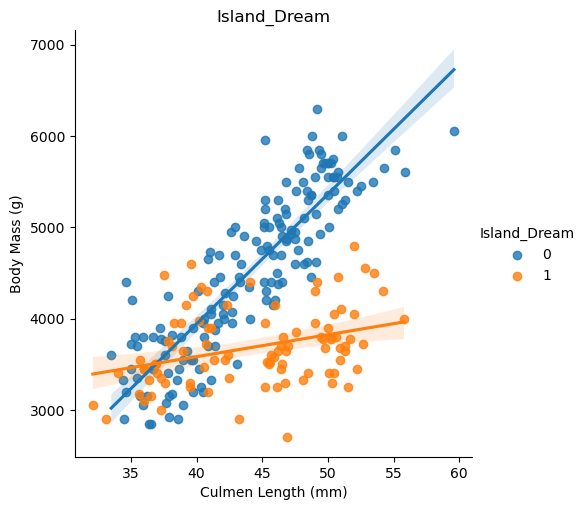

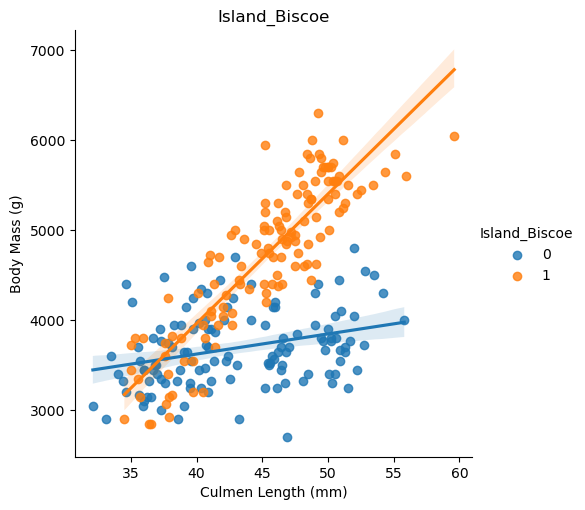

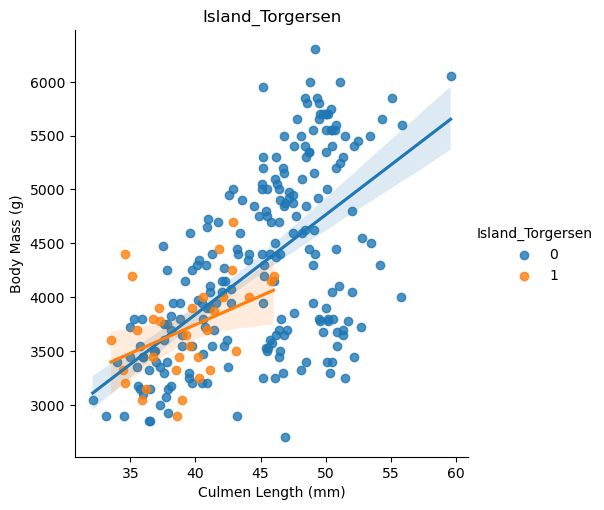

In [109]:
# Generate the three plots
g1 = sns.lmplot(
    data = X_train,
    x = "Culmen Length (mm)",
    y = "Body Mass (g)",
    hue = "Island_Dream"
)
g2 = sns.lmplot(
    data = X_train,
    x = "Culmen Length (mm)",
    y = "Body Mass (g)",
    hue = "Island_Biscoe"
)
g3 = sns.lmplot(
    data = X_train,
    x = "Culmen Length (mm)",
    y = "Body Mass (g)",
    hue = "Island_Torgersen"
)

# Add titles to the subplots
g1.ax.set_title("Island_Dream")
g2.ax.set_title("Island_Biscoe")
g3.ax.set_title("Island_Torgersen")

---

### Modeling

Here we are choosing the features (at least one qualitative and at least two quantitative). To do so, we are using the exhaustive search approach to go through all the features contained in the data set. We define two lists that contains the names of the qualitative and quantitative data in the data set, and we create a pandas dataframe that would later store the results of the cross-validation evaluation for each combination of features. We iterate through the two lists we created. We create a new LogisticRegression object and we use cross-validation to evaluate the performance of the logistic regression model using the current combination of features. 

In [194]:
#selecting the columns that we want
all_qual_cols = ["Clutch Completion", "Sex", "Island", "Stage"]
all_quant_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

scores_df = pd.DataFrame(columns=['Columns', 'Score'])

for qual in all_qual_cols: 
    qual_cols = [col for col in X_train.columns if qual in col]
  
    for pair in combinations(all_quant_cols, 2):
        cols = qual_cols + list(pair)  

        lr = LogisticRegression(max_iter = 10000) # included the max number of iterations because I kept getting warnings
        
        cv_mean = cross_val_score(lr, X_train[cols], y_train, cv = 10).mean()
        scores_df = pd.concat([scores_df, pd.DataFrame({'Columns': cols, 'Score': cv_mean})], ignore_index=True)

scores_df = scores_df.sort_values(by='Score', ascending=False).reset_index(drop=True) # sort score in decreasing order

scores_df.head()
features = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen']

After choosing our features, we train our model with those features. We get a 0.996 or 99.6% training accuracy. We then test the model and get a 1.0 or 100% testing accuracy.

In [195]:
lr = LogisticRegression(max_iter = 1000)
lr.fit(X_train[features], y_train)
lr.score(X_train[features], y_train)

0.99609375

In [196]:
test_url = "https://raw.githubusercontent.com/middlebury-csci-0451/CSCI-0451/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)

X_test, y_test = prepare_data(test)

lr.score(X_test[features], y_test)

1.0

We also tried training on a RandomForestClassifier model.

In [199]:
rf = RandomForestClassifier()
rf.fit(X_train[features], y_train)
rf.score(X_train[features], y_train)

1.0

In [200]:
rf.score(X_test[features], y_test)

0.9852941176470589

### Evaluation

Using the follow function, we will show the decision regions of the finished models.

In [191]:
def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
        XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

        for j in qual_features:
            XY[j] = 0
            
        XY[qual_features[i]] = 1
            
        p= model.predict(XY)
        p = p.reshape(xx.shape)
      
      
        # use contour plot to visualize the predictions
        axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
        ix = X[qual_features[i]] == 1
        # plot the data
        axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
        axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1])
      
        patches = []
        for color, spec in zip(["red", "green", "blue"], ["Adelie", "Chinstrap", "Gentoo"]):
            patches.append(Patch(color = color, label = spec))

        plt.legend(title = "Species", handles = patches, loc = "best")
      
        plt.tight_layout()

These are the decision regions for the LogisticRegression model. As you can see, the model did a really good job at classifying the three penguin species.

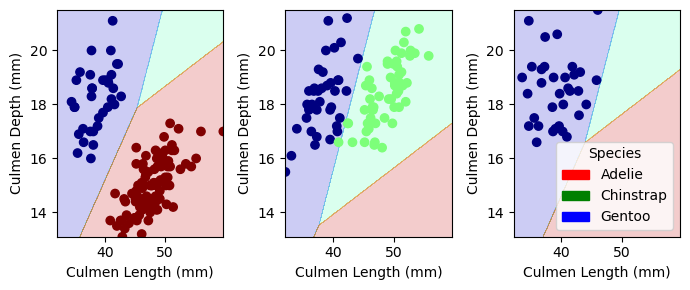

In [197]:
plot_regions(lr, X_train[features], y_train)

These are the decision regions for the RandomForestClassifier model. There may be a little bit of overfitting because of the jagged boundaries, however the model did a pretty good job at classifying the species.

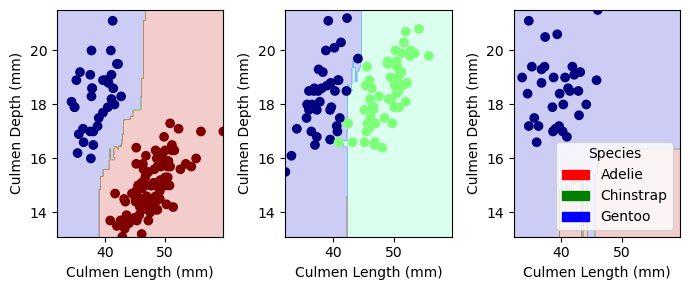

In [201]:
plot_regions(rf, X_train[features], y_train)